In [4]:
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

In [1]:
speech_path = 'assets/LANDR-Meditations- Mindful Beathing 15 Mins-Balanced-Medium.mp3'
music_path = 'assets/ambienceTrack_001(1).mp3'

In [28]:
from src.speech import SpeechInformationRetreiver

sir = SpeechInformationRetreiver(
    model_name='stt_en_fastconformer_hybrid_large_streaming_1040ms',
    lookahead_size=1040,
    decoder_type='rnnt',
    device='cpu'
)

/Users/soroush/Desktop/LUCID/Folly/src/speech/asr.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange
[NeMo W 2024-07-22 16:36:13 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
      warnings.warn(
    
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN th

[NeMo I 2024-07-22 16:36:15 cloud:58] Found existing object /Users/soroush/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_fastconformer_hybrid_large_streaming_1040ms/666909d8ac36ad698d0451f58f12594c/stt_en_fastconformer_hybrid_large_streaming_1040ms.nemo.
[NeMo I 2024-07-22 16:36:15 cloud:64] Re-using file from: /Users/soroush/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_fastconformer_hybrid_large_streaming_1040ms/666909d8ac36ad698d0451f58f12594c/stt_en_fastconformer_hybrid_large_streaming_1040ms.nemo
[NeMo I 2024-07-22 16:36:15 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-07-22 16:36:16 mixins:172] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2024-07-22 16:36:16 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /raid/local//bucket1/tarred_audio_manifest.json
    - - /raid/local//bucket2/tarred_audio_manifest.json
    - - /raid/local//bucket3/tarred_audio_manifest.json
    - - /raid/local//bucket4/tarred_audio_manifest.json
    - - /raid/local//bucket5/tarred_audio_manifest.json
    - - /raid/local//bucket6/tarred_audio_manifest.json
    - - /raid/local//bucket7/tarred_audio_manifest.json
    - - /raid/local//bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 1
    shuffle: true
    num_workers: 4
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 25
    min_duration: 0.1
    is_tarred: true
    tarred_audio_filepaths:
    - - /data2/nemo_asr/nemo_asr_set_3.0//bucket1/audi

[NeMo I 2024-07-22 16:36:16 features:305] PADDING: 0


[NeMo W 2024-07-22 16:36:17 nemo_logging:349] /Users/soroush/lucid_env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
      warnings.warn("dropout option adds dropout after all but last "
    


[NeMo I 2024-07-22 16:36:17 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001, 'clamp': -1.0}
[NeMo I 2024-07-22 16:36:17 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001, 'clamp': -1.0}


[NeMo W 2024-07-22 16:36:17 rnnt_loop_labels_computer:270] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2024-07-22 16:36:17 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001, 'clamp': -1.0}


[NeMo W 2024-07-22 16:36:17 rnnt_loop_labels_computer:270] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2024-07-22 16:36:17 save_restore_connector:263] Model EncDecHybridRNNTCTCBPEModel was successfully restored from /Users/soroush/.cache/torch/NeMo/NeMo_2.0.0rc1/stt_en_fastconformer_hybrid_large_streaming_1040ms/666909d8ac36ad698d0451f58f12594c/stt_en_fastconformer_hybrid_large_streaming_1040ms.nemo.
[NeMo I 2024-07-22 16:36:17 hybrid_rnnt_ctc_bpe_models:422] No `decoding_cfg` passed when changing decoding strategy, using internal config
[NeMo I 2024-07-22 16:36:17 rnnt_models:224] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.001, 'clamp': -1.0}


[NeMo W 2024-07-22 16:36:17 rnnt_loop_labels_computer:270] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2024-07-22 16:36:17 hybrid_rnnt_ctc_bpe_models:457] Changed decoding strategy of the RNNT decoder to 
    model_type: rnnt
    strategy: greedy_batch
    compute_hypothesis_token_set: false
    preserve_alignments: null
    confidence_cfg:
      preserve_frame_confidence: false
      preserve_token_confidence: false
      preserve_word_confidence: false
      exclude_blank: true
      aggregation: min
      tdt_include_duration: false
      method_cfg:
        name: entropy
        entropy_type: tsallis
        alpha: 0.33
        entropy_norm: exp
        temperature: DEPRECATED
    fused_batch_size: null
    compute_timestamps: null
    compute_langs: false
    word_seperator: ' '
    rnnt_timestamp_type: all
    greedy:
      max_symbols_per_step: 10
      preserve_alignments: false
      preserve_frame_confidence: false
      tdt_include_duration_confidence: false
      confidence_method_cfg:
        name: entropy
        entropy_type: tsallis
        alpha: 0.33
        en

In [29]:
asr_res = sir.recognize_file(speech_path)

  0%|          | 0/805 [00:00<?, ?it/s]

In [200]:
import src.speech.bridge
reload(src.speech.bridge)
from src.speech.bridge import SpeechBridge


bridge = SpeechBridge(num_keywords=5)
speech_segments = bridge.to_events(asr_res, max_dist=10., extract_kw=True)
len(speech_segments)

8

In [201]:
speech_segments

[{'text': 'meditation, sit, mindfulness, relaxation, breath',
  'start': 35.85590062111801,
  'end': 126.61614906832297,
  'duration': 90.76024844720496,
  'arousal': 0.3425825736632473,
  'valence': 0.4527522483415772,
  'dominance': 0.4466206155848085},
 {'text': 'breaths, exhale, breath, immersing, feeling',
  'start': 161.35155279503104,
  'end': 229.70186335403724,
  'duration': 68.3503105590062,
  'arousal': 0.33670357896222014,
  'valence': 0.3903557315137652,
  'dominance': 0.430416595670912},
 {'text': 'breath, meditation, rhythmic, rhythm, dance',
  'start': 292.4496894409938,
  'end': 357.4385093167702,
  'duration': 64.98881987577641,
  'arousal': 0.34769820994801,
  'valence': 0.401525159544415,
  'dominance': 0.4336150125331349},
 {'text': 'comforting, breast, breath, distractions, gentle',
  'start': 414.583850931677,
  'end': 491.8981366459627,
  'duration': 77.31428571428575,
  'arousal': 0.3478513020442592,
  'valence': 0.42234713011317787,
  'dominance': 0.4345483610

In [110]:
import src.music.mir 
reload(src.music.mir)
from src.music.mir import MusicInformationRetreiver

mir = MusicInformationRetreiver(weights_path='mir_weights/', segment_threshold=0.15)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//discogs-effnet-bs64-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_instrument-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//msd-musicnn-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//emomusic-msd-musicnn-2.pb`


In [111]:
mir_res = mir.recognize_file(music_path)

  0%|          | 0/30 [00:00<?, ?it/s]

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_genre-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `mir_weights//mtg_jamendo_instrument-discogs-effnet-1.pb`


In [202]:
import src.music.bridge
reload(src.music.bridge)
from src.music.bridge import MusicBridge


bridge = MusicBridge(mir.genre_classes, mir.inst_classes)
music_segments = bridge.extract_segments(mir_res, class_threshold=0.3)
len(music_segments)

9

In [204]:
music_segments

[{'start': 0,
  'end': 177.76,
  'duration': 177.76,
  'valence': 0.00077042304,
  'arousal': 0.0012349887,
  'text': 'ambient, electronic, synthesizer'},
 {'start': 177.76,
  'end': 463.2,
  'duration': 285.44,
  'valence': 0.00036098604,
  'arousal': 0.00062089675,
  'text': 'ambient, electronic, synthesizer'},
 {'start': 463.2,
  'end': 556.256,
  'duration': 93.05599999999998,
  'valence': 0.00047147647,
  'arousal': 0.0011773775,
  'text': 'ambient, electronic, synthesizer'},
 {'start': 556.256,
  'end': 605.184,
  'duration': 48.928,
  'valence': 0.00025228475,
  'arousal': 0.00054264185,
  'text': 'ambient, electronic, synthesizer'},
 {'start': 605.184,
  'end': 651.648,
  'duration': 46.464000000000055,
  'valence': 0.00030476876,
  'arousal': 0.00059747236,
  'text': 'ambient, electronic, synthesizer'},
 {'start': 651.648,
  'end': 694.88,
  'duration': 43.23199999999997,
  'valence': 0.00044553317,
  'arousal': 0.00089731644,
  'text': 'ambient, electronic, synthesizer'},
 {'

In [225]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segments(speech_segments, music_segments, add_text=True):
    # Sort segments by start time
    speech_segments.sort(key=lambda x: x['start'])
    music_segments.sort(key=lambda x: x['start'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

    # Plot speech segments
    speech_colors = plt.cm.rainbow(np.linspace(0, 1, len(speech_segments)))
    for idx, seg in enumerate(speech_segments):
        rect = plt.Rectangle(
            xy=(seg['start'], 0), 
            width=seg['end'] - seg['start'], 
            height=1, facecolor=speech_colors[idx], alpha=0.5, edgecolor='black'
        )
        ax1.add_patch(rect)
        
        if add_text:
            ax1.text(
                x=(seg['start'] + seg['end']) / 2, 
                y=0.5, 
                s=seg['text'].replace(', ', '\n'), 
                ha='center', va='center', fontsize=8, fontweight='bold', wrap=True
            )

    # Plot music segments
    music_colors = plt.cm.rainbow(np.linspace(0, 1, len(music_segments)))
    for idx, seg in enumerate(music_segments):
        rect = plt.Rectangle(
            xy=(seg['start'], 0), 
            width=seg['end'] - seg['start'], 
            height=1, facecolor=music_colors[idx], alpha=0.5, edgecolor='black'
        )
        ax2.add_patch(rect)
        
        if add_text:
            ax2.text(
                x=(seg['start'] + seg['end']) / 2, 
                y=0.5, 
                s=seg['text'].replace(', ', '\n'), 
                ha='center', va='center', fontsize=8, fontweight='bold', wrap=True
            )
    
    # Set y-axis limits and labels
    ax1.set_ylim(0, 1)
    ax1.set_yticks([])
    ax1.set_ylabel('Speech Segments')

    ax2.set_ylim(0, 1)
    ax2.set_yticks([])
    ax2.set_ylabel('Music Segments')
    ax2.set_xlabel('Time (s)')

    # Set x-axis limits to the full range of segments
    all_segments = speech_segments + music_segments
    if all_segments:
        ax1.set_xlim(min(seg['start'] for seg in all_segments), max(seg['end'] for seg in all_segments))

    plt.tight_layout()
    plt.show()


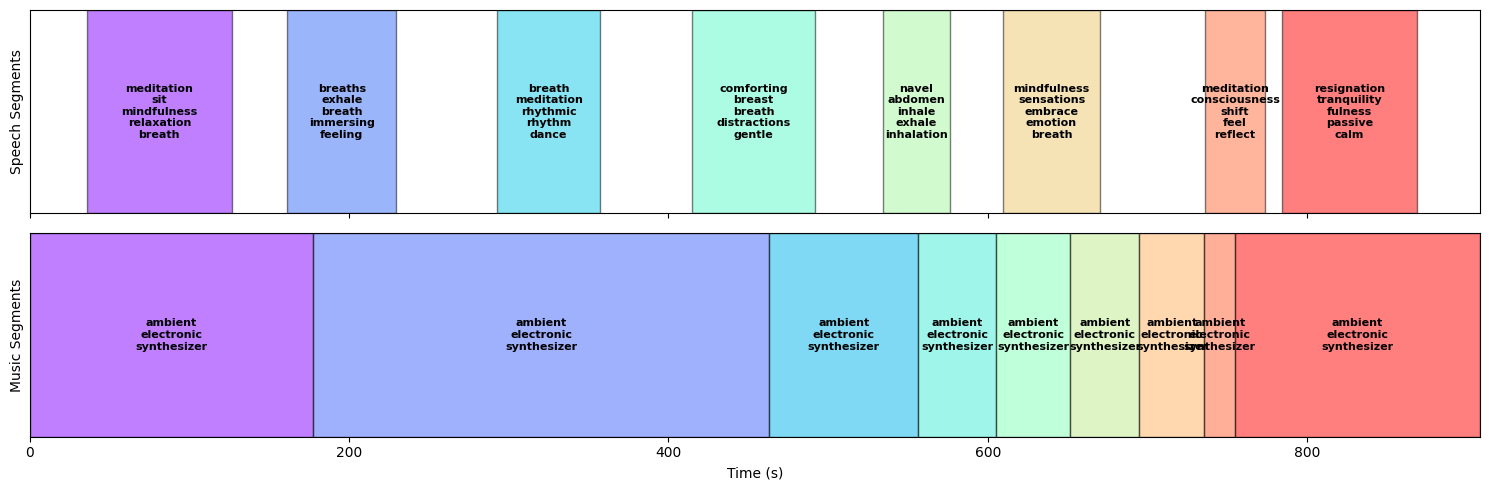

In [226]:
plot_segments(speech_segments, music_segments, add_text=True)